# Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Modelling using LSTM

## Loading Dependencies

In [1]:
import os
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras.losses import BinaryCrossentropy
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec, FastText

import emoji

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
SELECT * FROM `future-data-track-1.sapporo_mart.sampled_sentiment_analysis`;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review_key,review,rating,sentiment
0,WsCrUJqgK2vp/Gh7GqMjt9XbbVeYNWrH61bkkVoljlGxtg...,♥️♥️♥️♥️♥️♥️♥️♥️♥️♥️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️♥️♥️♥️...,5,2
1,uppDU9/aDAQsCKB0VPjK5W02w5Y4i311OUXUiTzq7FS/mI...,Aplikasi sangat mudah di gunakan...pembelian k...,5,2
2,u3skvq8AFPY8AyRClNpu1FBY6OvYO9oLG46N4r+E+tVjhQ...,Ok mantapppp,5,2
3,CmXw2IoVAxDT/Yj5qvplNhYnEmHMV+NO9ttccjjvEY56vy...,Opakah bener,5,2
4,0SXPdI+TMY952tiKAzXAHLI9hWh4dKgJ3yDsV5EvgJUVSs...,Cakep deh,5,2


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

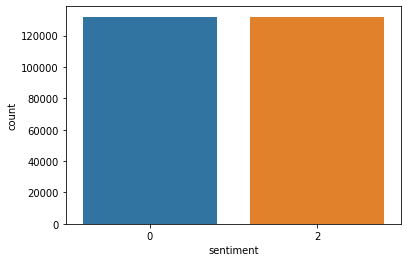

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review_key    0
review        0
rating        0
sentiment     0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264000 entries, 0 to 263999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   review_key  264000 non-null  object
 1   review      264000 non-null  object
 2   rating      264000 non-null  int64 
 3   sentiment   264000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 10.1+ MB


### Cleaning

In [9]:
def extract_emojis(sentence):
    return re.findall(emoji.get_emoji_regexp(), sentence)

In [10]:
def preprocessing_text(texts):
    emojis = extract_emojis(texts)
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts + emojis

In [11]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [12]:
df.head()

,review_key,review,rating,sentiment,review_cleaned
0,WsCrUJqgK2vp/Gh7GqMjt9XbbVeYNWrH61bkkVoljlGxtg...,♥️♥️♥️♥️♥️♥️♥️♥️♥️♥️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️♥️♥️♥️...,5,2,"[♥️, ♥️, ♥️, ♥️, ♥️, ♥️, ♥️, ♥️, ♥️, ♥️, ❤️, ❤..."
1,uppDU9/aDAQsCKB0VPjK5W02w5Y4i311OUXUiTzq7FS/mI...,Aplikasi sangat mudah di gunakan...pembelian k...,5,2,"[aplikasi, sangat, mudah, di, gunakan, pembeli..."
2,u3skvq8AFPY8AyRClNpu1FBY6OvYO9oLG46N4r+E+tVjhQ...,Ok mantapppp,5,2,"[ok, mantapppp]"
3,CmXw2IoVAxDT/Yj5qvplNhYnEmHMV+NO9ttccjjvEY56vy...,Opakah bener,5,2,"[opakah, bener]"
4,0SXPdI+TMY952tiKAzXAHLI9hWh4dKgJ3yDsV5EvgJUVSs...,Cakep deh,5,2,"[cakep, deh]"


In [13]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,264000.000000
mean,11.010208
std,13.957606
min,0.000000
25%,2.000000
50%,6.000000
75%,14.000000
max,257.000000


word_length    28.0
Name: 0.9, dtype: float64

## 2. LSTM Model

### Tokenize & Padding

In [14]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(df['review_cleaned'])

In [15]:
# tokenizer_file = open('Sentiment Analysis/Tokenizer/tokens_30k.json', 'r')

# tokenizer = tokenizer_from_json(tokenizer_file.read())

# tokenizer_file.close()

In [16]:
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
# X = pad_sequences(seq, maxlen=120, padding='post')
X = pad_sequences(seq, maxlen=70, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (264000, 70), X_min: 0, X_max: 29999


In [17]:
y = df['sentiment'].map({0:0, 2:1})

### Train-test split

In [18]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, stratify=y_train_valid)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(168960, 70) (42240, 70) (52800, 70) (168960,) (42240,) (52800,)


In [19]:
# EMBEDDING_FILEPATH = 'Sentiment Analysis/Embedding/w2v_emoji_sw_v4.w2v'

In [20]:
# embedding = Word2Vec.load(EMBEDDING_FILEPATH)

In [23]:
size = 100
window = 5
min_count = 2
workers = 2

embedding = FastText(df['review_cleaned'], min_count=min_count, vector_size=size, window=window, workers=workers, sg=1)

In [25]:
def get_weight_matrix(embedding: Word2Vec, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, 100))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding.wv.get_vector(word)
        except:
            continue
    
    return weight_matrix

In [26]:
embedding_vectors = get_weight_matrix(embedding, tokenizer.word_index)

In [27]:
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]

### Create Model Layers

In [28]:
embed_size = 100
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, weights=[embedding_vectors], input_length=max_length, trainable=True, mask_zero=True),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 100)           7418100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 7,460,405
Trainable params: 7,460,405
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [29]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/15
2640/2640 [==============================] - 651s 245ms/step - loss: 0.3696 - accuracy: 0.8500 - val_loss: 0.3638 - val_accuracy: 0.8543
Epoch 2/15
2640/2640 [==============================] - 573s 217ms/step - loss: 0.3374 - accuracy: 0.8656 - val_loss: 0.3639 - val_accuracy: 0.8531
Epoch 3/15
2640/2640 [==============================] - 575s 218ms/step - loss: 0.3279 - accuracy: 0.8692 - val_loss: 0.3821 - val_accuracy: 0.8527
Epoch 4/15
2640/2640 [==============================] - 581s 220ms/step - loss: 0.3230 - accuracy: 0.8712 - val_loss: 0.3800 - val_accuracy: 0.8504
Epoch 5/15
2640/2640 [==============================] - 582s 220ms/step - loss: 0.3178 - accuracy: 0.8734 - val_loss: 0.3779 - val_accuracy: 0.8511
Epoch 6/15
2640/2640 [==============================] - 576s 218ms/step - loss: 0.3162 - accuracy: 0.8739 - val_loss: 0.3843 - val_accuracy: 0.8488


<AxesSubplot:>

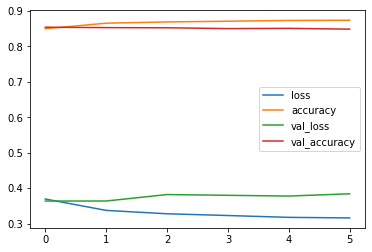

In [30]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     26400
           1       0.86      0.84      0.85     26400

    accuracy                           0.85     52800
   macro avg       0.85      0.85      0.85     52800
weighted avg       0.85      0.85      0.85     52800



<AxesSubplot:>

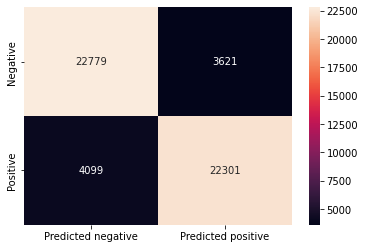

In [31]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Serializing Model

In [29]:
MODEL_NAME = 'LSTM_Sentiment_w2v'
MODEL_VERSION = (5, 0, 'E')
MODEL_FILENAME = '_'.join([MODEL_NAME, '.'.join(map(str, MODEL_VERSION))])
MODEL_FILENAME = os.path.join('Sentiment Analysis', 'LSTM', MODEL_FILENAME)

In [30]:
model.save(MODEL_FILENAME)

INFO:tensorflow:Assets written to: LSTM_Sentiment_4.0.E/assets
